# Predict tags on StackOverflow with linear models

### Text preprocessing

Neste exemplo, utilizaremos a lista de stopwords do NLTK

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Usaremos o dataset de títulos de posts do StackOverflow, dividido em *treino* e *teste*, contendo os títulos dos posts e as tags correspondentes (100 tags possíveis)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(eval)
    return data

In [ ]:
train = read_data('https://raw.githubusercontent.com/dblop/ml_tutorial/main/train.tsv')
validation = read_data('https://raw.githubusercontent.com/dblop/ml_tutorial/main/validation.tsv')

test = validation
#train = read_data('data/train.tsv')
#validation = read_data('data/validation.tsv')
#test = pd.read_csv('data/test.tsv', sep='\t')

In [ ]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


Os dados são formados de uma coluna *title*, que contém o título do post e uma *tags*, que contém a lista de tags do post

Vamos separar os targets para facilitar o processamento

In [ ]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values

A fim de padronizar os dados de treino, vamos remover alguns caracteres especiais, como traços e pontos, além de numerais.

In [ ]:
import re

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [ ]:
examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
clean_examples = [text_prepare(ex) for ex in examples]
clean_examples

['sql server equivalent excels choose function',
 'free c++ memory vectorint arr']

In [ ]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]

In [ ]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

Vamos calculcar quantas vezes cada palavra e cada tag ocorrem no nosso corpus

In [ ]:
from collections import Counter
from itertools import chain

tags_counts = Counter(list(chain.from_iterable(y_train)))
most_common_tags = [tuple([tag, count]) for tag, count in tags_counts.most_common()]

words_counts = Counter(list(chain.from_iterable([sentence.split() 
                                                 for sentence in X_train])))
most_common_words = [tuple([word, count]) for word, count in words_counts.most_common()]

In [ ]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:5]
most_common_tags

[('javascript', 19078),
 ('c#', 19077),
 ('java', 18661),
 ('php', 13907),
 ('python', 8940)]

In [ ]:
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5]
most_common_words

[('using', 8278),
 ('php', 5614),
 ('java', 5501),
 ('file', 5055),
 ('javascript', 4746)]

### Transformando texto em vetores

Os algoritmos de Machine Learning precisam que os dados sejam numéricos para serem executados. Para representar nossos dados numericamente, neste exemplo, utilizaremos o Bag of words.

#### Bag of words

Para criar a representação vetorial de um bag of words, devemos seguir os passos:
1. Encontre as *N* palavras mais populares e as enumere, a fim de selecionarmos os termos de maior ocorrência;
2. Para cada título/documento em nosso corpus, cria um vetor de zeros com *N* dimensões;
3. Para cada palavra em cada título/documento do cropus presente no dicionário, adicione 1 na posição da palavra no vetor correspondente ao título/documento.

Por exemplo, suponha que temos *N* = 4 e a lista das palavras mais comuns é:

    ['hi', 'you', 'me', 'are']

Assim, devemos enumera-las:

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

Sendo o texto que desejamos tranformar em números:

    'hi how are you'

Criamos o vetor de zeros:

    [0, 0, 0, 0]
    
Iteramos sobre todas as palavras, se ela estiver presente no dicionário, adicionamos 1 na posição correspondente.

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # a palavra 'how' não está presente no dicionário
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

Resutando:

    [1, 1, 0, 1]

In [ ]:
DICT_SIZE = 5000
INDEX_TO_WORDS = [key for key, count in words_counts.most_common()[:DICT_SIZE]]
WORDS_TO_INDEX = {word: i for i, word in enumerate(INDEX_TO_WORDS)}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1            
    return result_vector

In [ ]:
words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
examples = ['hi how are you']
bow = [my_bag_of_words(ex, words_to_index, 4)
       for ex in examples]
bow

[array([1., 1., 0., 1.])]

Para executarmos o método para todos nossos dados, vamos utilizar a matriz esparsa do scipy.
Como nosso bag of words possui muitos elementos iguais a 0 (são palavras que não ocrreram para aqule título ou documento), a estrutura de dados sp_sparse do scipy não alocará esses valores em memória, tornando mais eficiente a utiização desse recurso.

https://pt.wikipedia.org/wiki/Matriz_esparsa

In [ ]:
from scipy import sparse as sp_sparse

In [ ]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) 
                                  for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) 
                                for text in X_val])

print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)


#### TF-IDF

Uma outra abordagem utilizada é o tf-idf, que leva em consideração a frequência total de cada palavra em todo o corpus. Desta forma, substituímos o número de ocorrência de cada palavra no vetor, pelo TF * IDF, ou seja, frequência do termos vezes iverso da frequência no documento:

TF = (número de vezes que a palavra ocorre no texto) / (número total de palavras no texto)
IDF = (número total de documentos / número de documentos com a palavra *t* presente)

A fim de agilizar o tutorial, utilizaremos o tf-idf do sklearn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tfidf_features(X_train, X_val):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2), 
                                       token_pattern='(\S+)')
    
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    
    return X_train, X_val, tfidf_vectorizer.vocabulary_

In [ ]:
X_train_tfidf, X_val_tfidf, tfidf_vocab = tfidf_features(X_train, X_val)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [ ]:
tfidf_vocab['c++']

1976

Podemos obter o termo a partir do índice

In [ ]:
tfidf_reversed_vocab[1976]

'c++'

### Classificador MultiLabel 

Neste exemplo, cada texto pode ter mais de uma classe, para representar essas classes, utilizaremos o [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) do *sklearn*.

O MultiLabelBinarizer trabalhar de forma similar ao bag of words, ele cria um vetor de tamanho *M*, onde M é o número de classes, e marca como 1 as posições referentes às classes presentes

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Trataremos nossa abordagem multilabel com o [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html). Nesta abrodagem *k* classificcadores (= número de tags) são treinados, onde a função de cada um é identificar se a tag *t* é correspondente ao texto. Utilizaremos a regressão logística [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) como classificador básico.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [ ]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    clf = OneVsRestClassifier(LogisticRegression(penalty='l2', C=10.0))
    clf.fit(X_train, y_train)
    return clf

Treinaremos classificadores para ambos os métodos de vetorização: *bag-of-words* e *tf-idf*.

In [ ]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Agora, podemos classificar os dados

In [ ]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Vamos olhar o classificador com TF-IDF

In [ ]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(50, 60):
    print('Título:\t{}\nTags originais:\t{}\nTags preditas:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Título:	footer dont change opencart
Tags originais:	html,php
Tags preditas:	php


Título:	pool empty unable fetch connection 10 seconds
Tags originais:	java
Tags preditas:	


Título:	programatically finding message box generating click button
Tags originais:	.net,c#,winforms
Tags preditas:	c#


Título:	ensure php script ever run cron job
Tags originais:	php
Tags preditas:	php


Título:	statementsetfetchsize nsize method really sql server jdbc driver
Tags originais:	java,sql-server
Tags preditas:	java,sql-server


Título:	remove add functionality django admin
Tags originais:	django,python
Tags preditas:	django,python


Título:	passing multple files asterisk python shell windows
Tags originais:	python
Tags preditas:	python


Título:	inheritance templates c++ methods invisible
Tags originais:	c++
Tags preditas:	c++


Título:	servlet init method equivalent jaxrs
Tags originais:	java,servlets
Tags preditas:	java,servlets


Título:	file load zip zip missingsourcefile running cucumber
Tags or

### Evaluation

Vamos utilizar algumas métricas de avaliação:
 - [Acurácia](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 

In [ ]:
def print_evaluation_scores(y_val, predicted):
    
    print('acurácia', accuracy_score(predicted, y_val))
    print('f1-micro', f1_score(predicted, y_val, average='micro'))
    print('f1-macro', f1_score(predicted, y_val, average='macro'))
    print('f1-weighted', f1_score(predicted, y_val, average='weighted'))

In [ ]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
acurácia 0.34963333333333335
f1-micro 0.6681837604714252
f1-macro 0.507940707456799
f1-weighted 0.6915535566571677
Tfidf
acurácia 0.3633
f1-micro 0.6755121515440684
f1-macro 0.5062455445136486
f1-weighted 0.7065572244484265


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_auc(y_test, y_score, n_classes):  
    """Plots ROC curve for micro and macro averaging."""
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area     
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes 
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], 
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"], 
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(0,3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of ROC to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


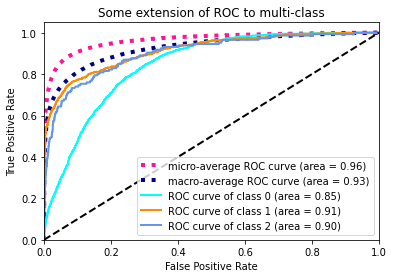

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


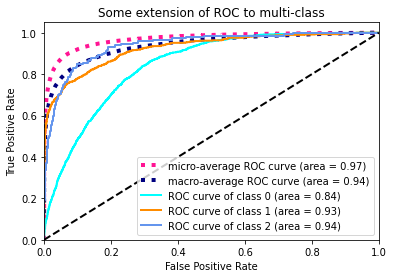

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

### Features mais importantes

Podemos utilizar os pesos da regressão logística para identificar as features mais importantes para a classificação de cada tag. Por exemplo

In [ ]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    

    est = classifier_tfidf.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]]
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [ ]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	printf, fscanf, scanf, malloc, c
Top negative words:	php, java, python, javascript, c#

Tag:	c++
Top positive words:	stdstring, mfc, boost, qt, c++
Top negative words:	java, php, python, javascript, c#

Tag:	linux
Top positive words:	dlopen, kernel space, system call, killed, linux
Top negative words:	javascript, c#, aspnet, codeigniter, nokogiri



In [ ]:
mlb.classes.index('c++')

11